# Homework 3: Text classification with Maximum Entropy model

Can we detect sarcasm in news article headlines?

In this homework, we will formulate a Maximum Entropy (MaxEnt) models to classify news headlines into sarcastic or not sarcastic.

## Bibliography

1. Misra, Rishabh and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019). https://arxiv.org/pdf/1908.07414.pdf
2. McCallum, Andrew, and Kamal Nigam. "A comparison of event models for naive bayes text classification." AAAI-98 workshop on learning for text categorization. Vol. 752. No. 1. 1998. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf
3. Kaggle dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

## News article headlines dataset

We will use the "Sarcasm headlines" dataset, collected by Ref. (1), and downloaded from Kaggle (3). The dataset consists of a series of headlines from news articles, classified as either being sarcastic, or not. The authors of (1) collected news from two sources: a serious news website (https://www.huffingtonpost.com), and an online newspaper that publishes satirical articles (https://www.theonion.com/). Headlines form the The Huffingtonpost were classified as non-sarcastic (`is_sarcastic=0`), and headlines from The Onion were classified as sarcastic (`is_sarcastic=1`).

**Data**. Two files have been prepared for this exercise: `train_data.json` containing the dataset that you will use to train the model, and `tests_data.json`, that you will use to evaluate the performance of the model. The following code will download these two data files for you.  

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

def parse_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        for l in file:
            yield json.loads(l)

train_data = list(parse_data('data/train_data.json'))
tests_data = list(parse_data('data/tests_data.json'))
all_data = train_data + tests_data

# Use less train data! (Question 5)
#train_data, tests_data = all_data[:2000], all_data[2000:]

# print some examples
print('train data:')
for d in train_data[:3]:
    print(d)
print('tests data:')
for d in tests_data[:3]:
    print(d)

train data:
{'is_sarcastic': 0, 'headline': 'sónar festival offers more than you might expect', 'article_link': 'https://www.huffingtonpost.com/entry/sonar-festival-offers-mor_b_5507780.html'}
{'is_sarcastic': 1, 'headline': '2013 year in review photo essay shaping up to be quite horrific', 'article_link': 'https://www.theonion.com/2013-year-in-review-photo-essay-shaping-up-to-be-quite-1819575009'}
{'is_sarcastic': 1, 'headline': 'angolan war criminal called in as character witness to manafort fraud trial', 'article_link': 'https://politics.theonion.com/angolan-war-criminal-called-in-as-character-witness-to-1828084812'}
tests data:
{'is_sarcastic': 1, 'headline': "mother comes pretty close to using word 'streaming' correctly", 'article_link': 'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'}
{'is_sarcastic': 1, 'headline': 'shadow government getting too large to meet in marriott conference room b', 'article_link': 'https://politics.theonion.co

As you can see, each data point is a Python dictionary with three fields:

1. `'is_sarcastic'`, a binary value, equal to 1 if the headline is sarcastic, and equal to 0 otherwise.
2. `'headline'`, the news article headline.
3. `'article_link'`, a link to the original news article. Although in principle inspecting the news article itself can provide more information, in this tutorial we will **not** do this. For simplicity, please ignore the `'article_link'` field.

In [26]:
# number of train and testing data points
print(len(train_data))
print(len(tests_data))

22895
5724


In [27]:
len(train_data) / (len(train_data) + len(tests_data))

0.7999930116356266

In [28]:
# access 'headline' of the news article #6 from the training dataset
train_data[5]['headline']

'world will miss goal for universal education by 50 years: un'

In [5]:
# collect all words in a single list (set discards duplicates)
all_words = list(set(word for doc in all_data for word in doc['headline'].split()))

# total number of words
L = len(all_words)
print(L)

38234


In [6]:
# dictionary giving the index of a word in the list
word_index = {word: i for (i, word) in enumerate(all_words)}

In [31]:
# index of word 'expertise' in the list of all words
word_index['expertise']

31008

## Question 1

We represent a headline as a binary vector, $\vec\sigma=\{σ_i\}_{i=1}^L$, where $σ_i = 1$ if word $i$ appears in the headline, and $σ_i = 0$ otherwise. The vector $\vec\sigma$ is of length $L$, which equals the total number of words considered (the vocabulary, `all_words` in the code above).

**Q1a):** This representation of texts is missing important aspects of language. Can you give a simple argument for why?

We will formulate two maximum entropy models (one for each class) matching the empirical frequencies of words in the train dataset for each class. Let $c=0,1$ be our label ($c=1$ for sarcastic headlines, $c=0$ otherwise). For each word, we define its empirical frequency in headlines of class $c$ as follows:

$$p_i(c) = \frac{1}{M_c}\sum_{\vec\sigma\in \mathcal D_c}\sigma_i$$

where $\mathcal D_c$ is the set of headlines of class $c$, and $M_c=|\mathcal D_c|$ is their number in our dataset. Notice that if a word appears more than once in a headline, it will still be counted as one. Since some rare words occur very few times in the data, it is recommended to add a *pseudo-count*,

$$p_i(c) = \frac{1}{M_c+1}\left(\sum_{\vec\sigma\in \mathcal D_c}\sigma_i + 1\right)$$

This avoids unintentional divisions by zero below. This procedure will be better justified in the following lectures when we discuss the role of the prior distributtion.

As shown in the lecture, the MaxEnt model matching these empirical frequencies for each class, is of the form:

$$P(\vec{\sigma}|c) = \frac{e^{\sum_i h_i(c)\sigma_i}}{Z(c)}$$

where

$$Z (c) = \sum_{\vec{\sigma}}e^{\sum_i h_i (c) \sigma_i} = \prod_i
\sum_{\sigma=0,1}e^{h_i (c) \sigma_i} = \prod_i (1 + e^{h_i (c)})$$

and the fields $h_i(c)$ are such that the moment-matching constraints are satisfied.

**Q1b)** Write the expression of the fields $h_i(c)$ to satisfy the moment-matching constraints $\langle \sigma_i \rangle_c = p_i(c)$, where $\langle . \rangle_c$ indicates the expectations under the model.

**Q1c)** Estimate the fields $h_i(c)$ for all the words in the full dataset, but using only the training data to estimate the empirical frequencies $p_i(c)$ (use the pseudocount, as explained above). Explain why the pseudo-count is necessary. *Hint: Consider a word that occurs in the testset, but not in the training set.*

## Answer to question 1

**Q1a):** This representation misses the number of times a work is used on a sentence and, order in which the words are used and commas, which are three things that a person play with when being sarcastic

**Q1b):** The moment matching condition gives

$$ p_i(c) = \langle \sigma_i \rangle _c = \frac{e^{h_i(c)}}{1 + e^{h_i(c)}} = \frac{1}{e^{-h_i(c)} + 1} $$

From which we get $ h_i(c) = \ln(p_i(c)) - \ln(1-p_i(c)) $

**Q1c):** The pseudocount is necessary because if the real count was used a word not present in the training set would make have $p_i(c) = 0$ making its field $ h_i(c) $ go to infinity. (Since it is highly not probable that a word is preent in all the headlines of a class, there is no need to make ulterior adjustment to regularize the $\ln(1-p_i(c))$ term). Hereby is the code to estimate al the $h_i(c)$ fields

In [32]:
# Code for question Q1c

#split train data into sarcastic and non sarcastic headlines
train_headlines = {0: [tat['headline']  for tat in train_data if not tat['is_sarcastic']], 1: [tat['headline']  for tat in train_data if tat['is_sarcastic']]}

#Now split the headlines and map every word to their index in all_words
train_indexes = {0: [word_index[wrd] for hdl in train_headlines[0] for wrd in hdl.split()],1: [word_index[wrd] for hdl in train_headlines[1] for wrd in hdl.split()]}

#Initialize the p_i(c) vector
pseudocount = np.ones((len(all_words),2)) #pseudocount[i,c] = p_i(c)

#Make the pseudocount
for c in [0,1]:
    for ind in train_indexes[c]:
        pseudocount[ind,c] += 1
    pseudocount[:,c] = pseudocount[:,c]/(len(train_headlines[c]) + 1)
    
#Calculate the h_i(c) field
h_field = np.log(pseudocount/(1-pseudocount)) #h_field[i,c] = h_i(c)


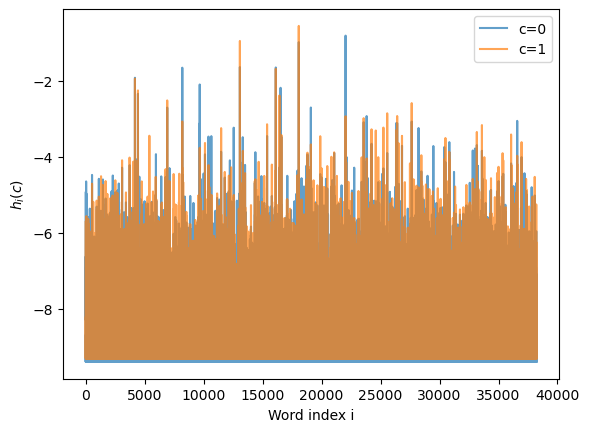

In [33]:
for c in [0,1]:
    plt.plot(h_field[:,c],alpha=0.7,label='c='+str(c))
plt.xlabel('Word index i')
plt.ylabel('$h_i(c)$')
plt.legend()
plt.show()

## Question 2.

**Q2a)** Plot the histogram of $\log P(\vec\sigma|c=1)$ for the sarcastic headlines, and for the serious headlines (in the same plot), for the test dataset. Are the histograms different?

**Q2b)** Plot the histogram of $\log\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}$ for the sarcastic headlines, and for the serious headlines. Are the histograms different?

**Bonus:** Same as b), but for $\log P(\vec\sigma|c=0)$.

**Q2c)** To give a quantitative measure of the separation of the two histograms above, you can compute the difference in means, normalized by the geometric mean of their standard deviations:

$$\frac{|\langle x\rangle - \langle y\rangle|}{\sqrt{\sigma_x \sigma_y}}$$

where $x,y$ denote the two kind of log-likelihoods or log-likelihood differences, considered in a), b).

## Answer for question 2

In [34]:
#Split test data into sarcastic and non sarcastic headlines
tests_headlines = {0: [tat['headline']  for tat in tests_data if not tat['is_sarcastic']], 1: [tat['headline']  for tat in tests_data if tat['is_sarcastic']]}

#Vectorize the tests data
tests_vectors = {0: np.zeros((len(tests_headlines[0]),len(all_words))), 1: np.zeros((len(tests_headlines[1]),len(all_words)))}
for c in [0,1]:
    for i in range(len(tests_headlines[c])):
        for wrd in tests_headlines[c][i].split():
            tests_vectors[c][i,word_index[wrd]] = 1
            
#Compute partition function
lnZ = np.sum(np.log(np.exp(h_field) + 1), 0)

#Compute the P(vec(sigma)|c)
lnP = [[0,0],[0,0]]
for s in [0,1]:
    for c in [0,1]:
        lnP[s][c] = np.dot(tests_vectors[s],h_field[:,c]) - lnZ[c]

**Q2a):** (also the bonus)

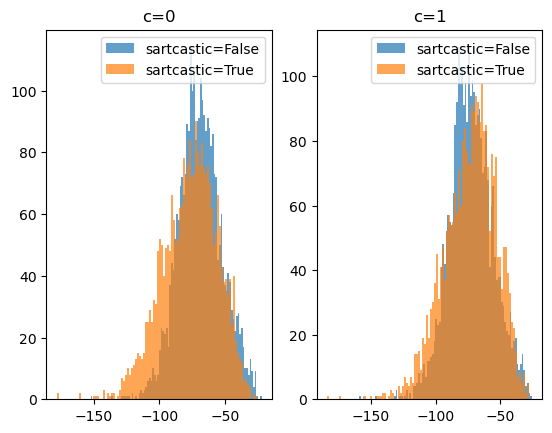

In [35]:
#Plot for question Q2a
fig, ax = plt.subplots(1,2)
for c in [0,1]:
    for s in [0,1]:
        ax[c].hist(lnP[s][c],100,alpha=0.7,label='sartcastic='+str(bool(s)))
    ax[c].set_title('c='+str(c))
    ax[c].legend()
plt.show()

**Q2b):**

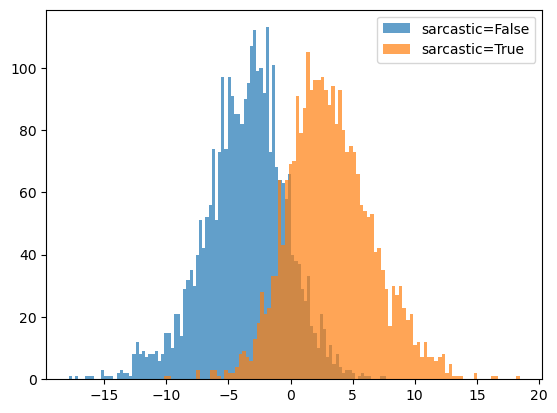

In [36]:
#Plot for question Q2b
difflnP = []
for s in [0,1]:
    difflnP.append(lnP[s][1] - lnP[s][0])
    plt.hist(difflnP[s],100,alpha=0.7,label='sarcastic='+str(bool(s)))
plt.legend()
plt.show()

**Q2c):**

In [37]:
hist_dist = {}
for c in [0,1]:
    hist_dist[c] = np.abs(lnP[1][c].mean() - lnP[0][c].mean())/np.sqrt(lnP[1][c].std()*lnP[0][c].std())
    print('The histogram distance for c='+str(c)+' is '+str(hist_dist[c]))
    
hist_dist['diff'] = np.abs(difflnP[1].mean() - difflnP[0].mean())/np.sqrt(difflnP[1].std()*difflnP[0].std())
print('The histogram distance for the difference of the two cases is '+str(hist_dist['diff']))

The histogram distance for c=0 is 0.41175378191474515
The histogram distance for c=1 is 0.041387529469986514
The histogram distance for the difference of the two cases is 2.062078816539612


## Question 3

**Q3a)** Using Bayes theorem, compute the ratio $P(c=1|\vec{\sigma})/P(c=0|\vec{\sigma})$ for the headlines in your testing set (note that $P(\vec{\sigma})$ cancels). To obtain an empirical estimate of $P(c)$, you can count the number of headlines in each class of the training set. Your classifier will use these ratios as the scores to predict the label of a headline.

**Q3b)** How accurate is this classifier? To quantify this, plot the Receiver Operating Characteristic Curve (ROC) and compute the Area Under the Curve (AUC). See Appendix for an explanation of the ROC and the AUC.

*Hint: The ROC curve is easier to obtain if you assume that the scores are sorted. You can also use the functions `roc_curve` and `auc` from the python package `sklearn`.*

**Bonus:** What is the ROC curve and AUC of a random classifier (that emits random labels for each headline)? What is the ROC curve and AUC of a perfect classifier (that emits the correct label for every headline)?

**Bonus:** Describe the connection between the areas under the histogram  curves of exercise 2 from d) and the AUC.

**(BONUS) Q3c)** Estimate the mutual information between the headline and the label,

$$MI(\vec\sigma,c)=\sum_{\vec\sigma,c}P(\vec\sigma,c)\ln\left(\frac{P(\vec\sigma,c)}{P(\vec\sigma)P(c)}\right)$$

Using the exact expression is intractable. However, you can obtain a practical estimate by approximating the outer average over the model distribution $P(\vec\sigma,c)$, with an empirical average over your data,

$$MI(\vec\sigma,c)\approx\frac{1}{M}\sum_d\ln\left(\frac{P(\vec\sigma_d,c_d)}{P(\vec\sigma_d)P(c_d)}\right)$$

where the sum over $d$ goes over the labeled headlines $\vec\sigma_d,c_d$ of your dataset. Estimate $MI(\vec\sigma,c)$ using this approximate expression for your training set and your testing set.

## Answer to question 3

**Q3a):** By Bayes theorem $ P(c|\vec{\sigma}) = P(\vec{\sigma}|c)P(c)/P(\vec{\sigma}) $ So that we have

$$ \frac{P(c=1|\vec{\sigma})}{P(c=0|\vec{\sigma})} = \frac{P(\vec{\sigma}|c=1)P(c=1)}{P(\vec{\sigma}|c=0)P(c=0)} \qquad \ln\left(\frac{P(c=1|\vec{\sigma})}{P(c=0|\vec{\sigma})}\right) = \ln\left(\frac{P(\vec{\sigma}|c=1)}{P(\vec{\sigma}|c=0)}\right) + \ln\left(\frac{P(c=1)}{P(c=0)}\right) $$

Putting it into code:

In [38]:
train_cratio10 = len(train_headlines[1])/len(train_headlines[0]) #We calculate P(c=1)/P(c=0)

Pcratio10_cnd = []
for s in [0,1]:
    Pcratio10_cnd.append(np.exp(difflnP[s])*train_cratio10)

**Q3b):**

In [2]:
from sklearn.metrics import roc_curve, auc

In [40]:
#Put the scores and the truths in 1D arrays
tests_scores = np.concatenate([Pcratio10_cnd[0],Pcratio10_cnd[1]])
tests_truths = np.concatenate([np.zeros(len(Pcratio10_cnd[0])),np.ones(len(Pcratio10_cnd[1]))])

#Compute the ROC curve
fpr , tpr, tresh = roc_curve(tests_truths, tests_scores)

#Calculate the area under curve and print it
tests_roc_auc = auc(fpr, tpr)
print('The AUC of the ROC is '+str(tests_roc_auc))

The AUC of the ROC is 0.9375671123276135


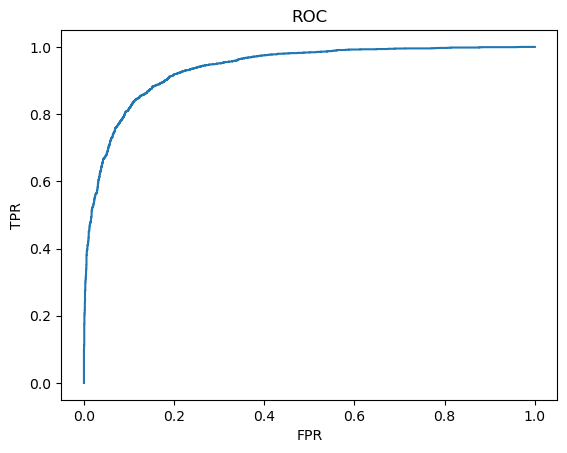

In [41]:
#Plot the ROC curve
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

*Bonus:* For a random classifier the ROC follows $TPR(t)=FPR(t)$ and $AUC = 0.5$ while for a perfect classifier the ROC is the concatenation of the segments $(0,0)\rightarrow(0,1)$ and $(0,1)\rightarrow(1,1)$ and has $AUC=1$

**Q3c:** To recycle the most as possible the terms that we alread calculated we use the devinition of conditional expectation $P(\vec{\sigma}_d,c_d) = $P(c_d|\vec{\sigma})P(\vec{\sigma})$ to rewrite

$$MI(\vec\sigma,c)\approx\frac{1}{M}\sum_d\ln\left(\frac{P(\vec\sigma_d,c_d)}{P(\vec\sigma_d)P(c_d)}\right) = \frac{1}{M}\sum_d \ln \left(\frac{P(\vec\sigma_d|c_d)}{P(\vec\sigma_d)}\right) = \frac{1}{M}\sum_d \ln \left(\frac{P(\vec\sigma_d|c_d)}{P(\vec\sigma_d|c=0)P(c=0)+P(\vec\sigma_d|c=1)P(c=1)}\right)$$

Where we used $P(\vec\sigma_d) = 1/M$ since we put an uniform prior on all the headlines

In [46]:
M = len(tests_data)
Pc = np.array([1,train_cratio10])/(1+train_cratio10)
lnP_word = [np.log(np.exp(lnP[0][1])*Pc[1] + np.exp(lnP[0][0])*Pc[0]), np.log(np.exp(lnP[1][1])*Pc[1] + np.exp(lnP[1][0])*Pc[0])]
tests_MI = ((lnP[1][1] - lnP_word[1]).sum() + (lnP[0][0] - lnP_word[0]).sum())/M

print('The mutual information is ', tests_MI )

The mutual information is  0.35536327567524534


## Question 4

Compute the Kullback-Leiber (KL) divergences between the 2 models,

$$D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1))$$

and

$$D_{KL}(P(\vec\sigma|c=1) || P(\vec\sigma|c=0))$$

Why are the two KL divergences different?

**Q4a)** Show that the KL divergences above, are sums of contributions for each word. Derive analytical expressions, as functions of the fields $h_i(c)$ in each case.

**Q4b)** Consider the task of classifying a newspaper as publishing sarcastic or non-sarcastic news articles. Estimate (approximatey) how many headlines your model will need to guess the correct classification confidently (with a probability of error below $10^{-10}$), assuming that in reality, i) the news-source publishes sarcastic headlines, or ii) the news-source publishes serious articles.

**Q4c)** To model different newspapers, construct datasets $D_1(c=1), D_2(c=1), \dots, D_{10}(c=1)$ consisting of different numbers of sarcastic headlines only, by taking the first 5, 10, 15, ..., 50, sarcastic headlines from the test dataset. Similarly, construct datasets $D_1(c=0), D_2(c=0), \dots, D_{10}(c=0)$ consisting of serious headlines only, by taking the first 5, 10, 15, .. 50 serious headlines from the test dataset. Compute the log-likelihood of each of these datasets under the two models $P(\vec\sigma|c=0,1)$.

**Q4d)** Plot the log-likelihood difference versus the number of headlines in each of the datasets constructed in c). What is the expected slope of this plot?

**Q4e)** Plot the log-likelihood difference per headlines (i.e., divided by number of headlines), versus the number of headlines in each of the datasets constructed in c). What is the expected asymptotic of this plot?

## Answer to question 4

**Q4a):** 
$$D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1)) = \sum_{\vec\sigma} P(\vec\sigma|c=0)\ln\left(\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}\right) $$

Recalling the formula $P(\vec\sigma|c) = e^{\sum_i h_i(c)\sigma_i}/Z(c) = \prod_i \frac{e^{h_i(c)\sigma_i}}{1 + e^{h_i(c)}} $ we have 

$$ \sum_{\vec\sigma} P(\vec\sigma|c=0)\ln\left(\frac{P(\vec\sigma|c=1)}{P(\vec\sigma|c=0)}\right) = \left(\sum_{\vec\sigma} P(\vec\sigma|c=0)\sum_i \left(h_i(1)-h_i(0)\right)\sigma_i\right) - \ln\left(\frac{Z(1)}{Z(0)}\right)$$

Now let's concentrate on the first term, we can write

\begin{align*}
\sum_{\vec\sigma} P(\vec\sigma|c=0)\sum_i \left(h_i(1)-h_i(0)\right)\sigma_i = \sum_{\vec\sigma}\sum_i \left(h_i(1)-h_i(0)\right) P(\vec\sigma, \sigma_i=1|c=0)  \\
= \sum_i\sum_{\vec\sigma}  \left(h_i(1)-h_i(0)\right)P(\vec\sigma|c=0, \sigma_i=1)P(\sigma_i=1|c=0) \\
= \sum_i  \left(h_i(1)-h_i(0)\right)P(\sigma_i=1|c=0)\sum_{\vec\sigma}P(\vec\sigma|c=0, \sigma_i=1) = \sum_i \frac{h_i(1)-h_i(0)}{1 + e^{-h_i(0)}}
\end{align*}

Where in the last line we used that $ P(\sigma_i=1|c=0) = e^{h_i(0)}/(1+e^{h_i(0)}) $.
Saperatn the partition functions in their components we then have

$$ D_{KL}(P(\vec\sigma|c=0) || P(\vec\sigma|c=1)) = \sum_i \left(\frac{h_i(1)-h_i(0)}{1 + e^{-h_i(0)}} - \ln\left(\frac{1 + e^{h_i(0)}}{1 + e^{h_i(1)}}\right)\right) $$

And similarly

$$ D_{KL}(P(\vec\sigma|c=1) || P(\vec\sigma|c=0)) = \sum_i \left(\frac{h_i(0)-h_i(1)}{1 + e^{-h_i(1)}} - \ln\left(\frac{1 + e^{h_i(1)}}{1 + e^{h_i(0)}}\right)\right) $$


**Q4b):** Using the $D_{KL}$ we get that we need 7 correct guesses to get a serious journal and 4 to get a sarcastic one

In [62]:
DKL01 = ((h_field[:,1] - h_field[:,0])/(1+np.exp(-h_field[:,0])) - np.log((1+np.exp(h_field[:,0]))/(1+np.exp(h_field[:,1])))).sum()
DKL10 = ((h_field[:,0] - h_field[:,1])/(1+np.exp(-h_field[:,1])) - np.log((1+np.exp(h_field[:,1]))/(1+np.exp(h_field[:,0])))).sum()

print(DKL01/np.log(10),DKL10/np.log(10))

-1.4162814954378877 -2.9137784139095233


**Q4c):**

In [67]:
partial_llh = np.zeros((2,2,10))
nbs = np.arange(10)*5+5
for s in [0,1]:
    for c in [0,1]:
        for d in range(len(nbs)):
            partial_llh[s,c,d] = lnP[s][c][:nbs[d]].sum()

**Q4d):**

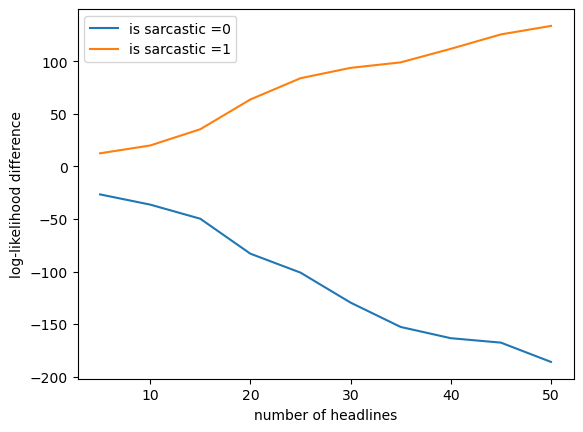

In [68]:
for s in [0,1]:
    plt.plot(nbs,partial_llh[s,1,:]-partial_llh[s,0,:],label='is sarcastic ='+str(s))
plt.legend()
plt.ylabel('log-likelihood difference')
plt.xlabel('number of headlines')
plt.show()

**Q4e):**

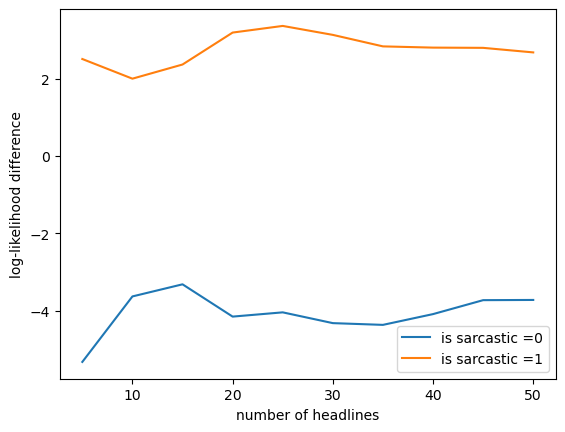

In [69]:
for s in [0,1]:
    plt.plot(nbs,(partial_llh[s,1,:]-partial_llh[s,0,:])/nbs,label='is sarcastic ='+str(s))
plt.legend()
plt.ylabel('log-likelihood difference')
plt.xlabel('number of headlines')
plt.show()

## Question 5

In the previous exercises, your training dataset contained $\approx 80\%$ of headlines in your entire dataset. Repeat exericses 1-4, but reducing your training dataset to only the first 100, 1000, and 10000 headlines, assigning all the remaining headlines to the testing set. Discuss the impact on the performance of the model of the limited training data. Plot the AUC for the different sizes of training data, and the score computed in Q2c. *Hint: You can just modify the definition of `train_data` in the first cell of this notebook and re-run everything else!*

In [9]:
def boltzmann_auc (trains_data, testss_data):
    train_headlines = {0: [tat['headline']  for tat in trains_data if not tat['is_sarcastic']], 1: [tat['headline']  for tat in trains_data if tat['is_sarcastic']]}
    train_indexes = {0: [word_index[wrd] for hdl in train_headlines[0] for wrd in hdl.split()],1: [word_index[wrd] for hdl in train_headlines[1] for wrd in hdl.split()]}
    pseudocount = np.ones((len(all_words),2)) #pseudocount[i,c] = p_i(c)
    for c in [0,1]:
        for ind in train_indexes[c]:
            pseudocount[ind,c] += 1
        pseudocount[:,c] = pseudocount[:,c]/(len(train_headlines[c]) + 1)
    h_field = np.log(pseudocount/(1-pseudocount)) #h_field[i,c] = h_i(c)
    tests_headlines = {0: [tat['headline']  for tat in testss_data if not tat['is_sarcastic']], 1: [tat['headline']  for tat in testss_data if tat['is_sarcastic']]}
    tests_vectors = {0: np.zeros((len(tests_headlines[0]),len(all_words))), 1: np.zeros((len(tests_headlines[1]),len(all_words)))}
    for c in [0,1]:
        for i in range(len(tests_headlines[c])):
            for wrd in tests_headlines[c][i].split():
                tests_vectors[c][i,word_index[wrd]] = 1
    lnZ = np.sum(np.log(np.exp(h_field) + 1), 0)
    lnP = [[0,0],[0,0]]
    for s in [0,1]:
        for c in [0,1]:
            lnP[s][c] = np.dot(tests_vectors[s],h_field[:,c]) - lnZ[c]
    train_cratio10 = len(train_headlines[1])/len(train_headlines[0]) #We calculate P(c=1)/P(c=0)
    Pcratio10_cnd = []
    for s in [0,1]:
        Pcratio10_cnd.append(np.exp(lnP[s][1] - lnP[s][0])*train_cratio10)
    tests_scores = np.concatenate([Pcratio10_cnd[0],Pcratio10_cnd[1]])
    tests_truths = np.concatenate([np.zeros(len(Pcratio10_cnd[0])),np.ones(len(Pcratio10_cnd[1]))])
    fpr , tpr, tresh = roc_curve(tests_truths, tests_scores)
    return auc(fpr, tpr)


In [ ]:
nums = np.array([100,200,500,1000,2000,5000,10000])
aucs = []
for n in nums:
    aucs.append(boltzmann_auc(all_data[:n],all_data[n:]))

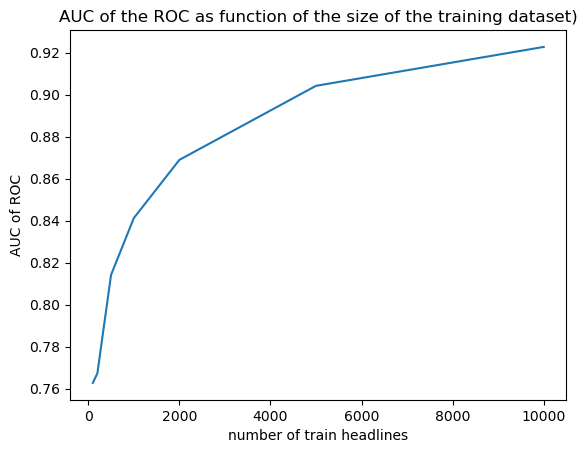

In [13]:
plt.plot(nums,aucs)
plt.title('AUC of the ROC as function of the size of the training dataset)')
plt.xlabel('number of train headlines')
plt.ylabel('AUC of ROC')
plt.show()

In [76]:
print(aucs)

[0.9375671123276135, 0.9375671123276135, 0.9375671123276135, 0.9375671123276135, 0.9375671123276135, 0.9375671123276135, 0.9375671123276135]


# Appendix: ROC and AUC

Giving predicted scores $S_i$ (in the exercises above you will use the odds ratio $P(c=1|\vec\sigma)/P(c=0|\vec\sigma)$ of the headlines $\vec\sigma_i$, and their true labels, $y_i=0,1$, we consider a threshold $t$ and assume that headlines for which $S_i > t$ are predicted to be sarcastic, while those for which $S_i\le t$ are predicted to be non-sarcastic. We define:

$$TP(t) = \text{number of true positives}\quad
(S_i > t\, \text{and}\, y_i=1)$$
$$FP(t) = \text{number of false positives}\quad
(S_i > t\, \text{and}\, y_i=0)$$

That is, $TP(t)$ is the number of correctly classified positive (sarcastic) headlines, and $FP(t)$ is the number of wrongly classified negative (non-sarcastic) headlines. In addition, let $P$ be the total number of sarcastic headlines in the data, and $N$ the total number of non-sarcastic headlines. Finally we define:

$$TPR(t) = \frac{TP(t)}{P} ,\qquad FPR(t) = \frac{FP(t)}{N}$$

The ROC curve is defined as the parametric curve $(FPR(t), TPR(t))$, traversed as the threshold takes all possible values, $-\infty<t<\infty$. Notice that $0\le TPR(t)\le1$ and $0\le FPR(t)\le1$, and that:

$$TPR(-\infty)=FPR(-\infty)=1,\qquad TPR(\infty)=FPR(\infty)=0$$

The AUC is defined as the area under this curve:

$$AUC = \int_{t=-\infty}^\infty TPR(t) \times \mathrm d FPR(t)
= \int_{t=-\infty}^\infty TPR(t) \times \frac{\mathrm d FPR(t)}{\mathrm d t} \mathrm{d}t$$